# Continuous Wave ODMR

A code that executes CWODMR using the CWODMR experiment class in qt3utils.

This code has been testing in the QT3 lab as of Mar 29, 2023. It should work on similar setups that 
utilize supported NiDAQ cards for TTL edge counting (where TTL signals are produced by photon detection), 
a SpinCore PulseBlaster for TTL pulses that 
control an AOM for laser control, a swtich for MW pulses and provide clock and trigger signals to the 
NiDAQ, and a Windfreak RF Synthesizer to generate the MW source.

The code in this notebook is organized as follows

1. Import the necessary Python packages for data acquisition and plotting
2. Create necessary hardware control objects
3. Create the CWODMR experiment object
4. Run the experiment
5. Display the ODMR spectrum

More details of experiment classes in qt3utils [can be found here](../docs/ExperimentsDoc.md).

# Import Packages

In [1]:
# Jupyter magic functions are useful during development, but are not necessary. You may comment these out if desired.
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import logging

In [4]:
import qt3utils.experiments.cwodmr
from qt3utils.pulsers.pulseblaster import PulseBlasterCWODMR
import qt3utils.nidaq
import qt3rfsynthcontrol

Should you encounter bugs or problems, please report the version number of the qt3utils package with your Issue. 

In [5]:
import qt3utils
print(qt3utils.__version__)

1.0.3.dev0


### Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [6]:
logging.basicConfig(level=logging.WARNING)
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)

# Create objects to control the hardware

We need
* `qt3rfsynthcontrol` to control Windfreak RF Generator
* `PulseBlasterCWODMR` object to control PulseBlaster TTL
* `nidaq.EdgeCounter` to configure NiDAQ card.

The Windfreak RF generator is connected via USB. You must first determine the name of the USB port the Windfreak device is connected to. Then create an object with that USB port name. 

In [7]:
qt3rfsynthcontrol.discover_devices()

[['COM3',
  'Intel(R) Active Management Technology - SOL (COM3)',
  'PCI\\VEN_8086&DEV_43E3&SUBSYS_0A541028&REV_11\\3&11583659&1&B3'],
 ['COM5',
  'USB Serial Device (COM5)',
  'USB VID:PID=0483:A3E5 SER=206A36705430 LOCATION=1-9:x.0'],
 ['COM6',
  'piezojena NV40/3CL USB (COM6)',
  'USB VID:PID=0403:D161 SER=714151A'],
 ['COM7',
  'USB Serial Device (COM7)',
  'USB VID:PID=239A:8014 SER=3B0D07C25831555020312E341A3214FF LOCATION=1-5:x.0'],
 ['COM8', 'USB Serial Port (COM8)', 'USB VID:PID=0647:0100 SER=22062107A']]

In [8]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

The PulseBlaster object has a number of parameters to describe which channel (or "bit") output is connected to various lab hardware. See [pulse_blaster_testing.ipynb](pulse_blaster_testing.ipynb) for some more detail usage. The default values for the parameters are set to match the current hardware configuration in the QT3 lab. 

In [9]:
cwodmr_pulser = PulseBlasterCWODMR(pb_board_number=0, clock_period = 100e-9)

Each PulseBlaster class (and each qt3utils.experiment class) has a method called `experimental_conditions` that returns a dictionary with pertinent information for that particular object. In this case, the RF pulse duration is provided (5 microseconds), as well as the clock period. 

In [10]:
cwodmr_pulser.experimental_conditions()

{'rf_pulse_duration': 5e-06, 'clock_period': 1e-07}

In [11]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Instantiate an experiment object

Using our objects that communicate with our hardware, we can now create a CWODMR experiment. 

The CWODMR experiment can be created with a number of different input parameters not shown here. 
Those parameters include the experimental conditions and hardware connections (which channels
of the NiDAQ card are connected to clock, trigger, and PL signal). Default paramters match current
QT3 hardware configuration. For full description, use the help function of Jupyter `?`.

In [ ]:
qt3utils.experiments.cwodmr.CWODMR?

In [12]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config, rf_power=-20)

After an experiment object is instantiated, you may still change the conditions of the experiment if desired. For example, we change the rf pulse duration to 10 microseconds, then increase the range of RF frequencies in our scan and the step size between RF frequencies.

In [13]:
cwodmr_pulser.rf_pulse_duration = 10e-6

In [14]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -20,
 'pulser': {'rf_pulse_duration': 1e-05, 'clock_period': 1e-07}}

In [15]:
cwodmr_exp.freq_low = 2730e6
cwodmr_exp.freq_high = 3030e6
cwodmr_exp.freq_step = 2e6
cwodmr_exp.rf_power = -10

All qt3utils experiment classes are executed with the `run` function. See the [documentation for more information](../docs/ExperimentsDoc.md).

The return from this call will be a numpy array of shape (N, 2).

Due to our logger configured above `qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)`, the `run` 
method reports the start of acquisition at each frequency below. This can be turned off by using
`logging.WARNING`. 

In [16]:
scan_data = cwodmr_exp.run(N_cycles=40000)

INFO:qt3utils.experiments.cwodmr:RF frequency: 2730000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2732000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2734000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2736000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2738000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2740000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2742000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2744000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2746000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2748000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2750000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2752000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2754000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2756000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2758000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 27600000

INFO:qt3utils.experiments.cwodmr:RF frequency: 2992000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2994000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2996000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 2998000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3000000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3002000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3004000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3006000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3008000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3010000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3012000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3014000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3016000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3018000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 3020000000.0 Hz
INFO:qt3utils.experiments.cwodmr:RF frequency: 30220000

# Observe the Data

The first column of `scan_data` is the experimental variable (in this case the RF frequency) and the second column contains the measured contrast. In the data below we can see three Zeeman splittings, where, presumably, two of the NV- orientations are equally split by the static magnetic field. 

<IPython.core.display.Javascript object>


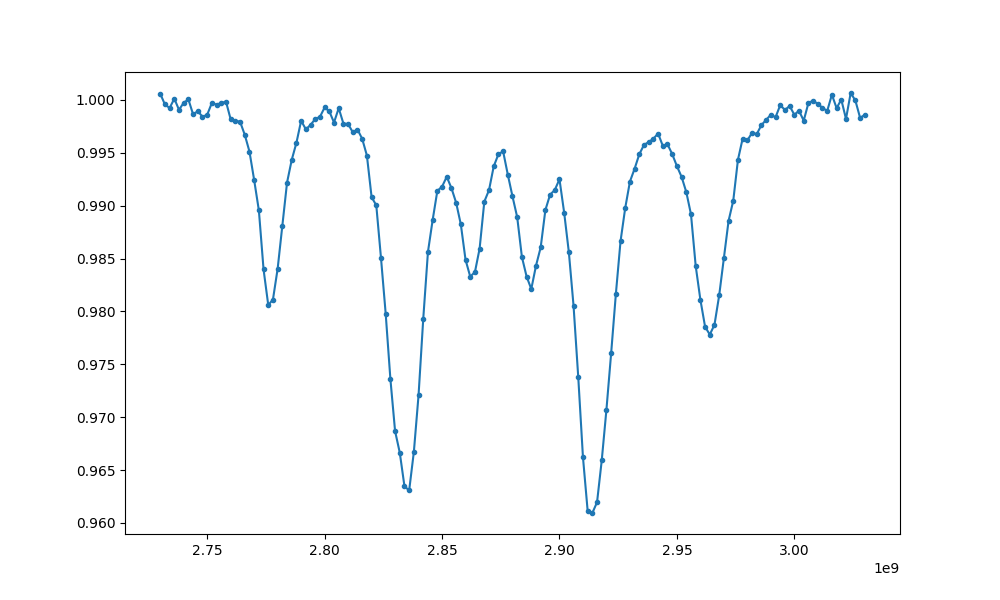

In [17]:
plt.figure(figsize=(10,6))
x_data = scan_data[:, 0]
y_data = scan_data[:, 1]
plt.plot(x_data, y_data, '.-')